# 预处理文件
将数据集中的图片重新分配路径

In [1]:
import os
import shutil

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)


train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)  #找出训练集中所有猫的照片
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)  #找出训练集中所有狗的照片

rmrf_mkdir('train_data')   #创建训练集文件夹
os.mkdir('train_data/cat')
os.mkdir('train_data/dog')

rmrf_mkdir('val_data')     #创建验证集文件夹
os.mkdir('val_data/cat')
os.mkdir('val_data/dog')

train_val_split_precent = int(25000*0.8/2)   #训练集为20000张，验证集为5000张，猫狗各一半

count = 0
for filename in train_cat:
    if count < train_val_split_precent:
        os.symlink('../../train/'+filename, 'train_data/cat/'+filename) #将所有猫的照片的symlink放入train_data/cat/
        count += 1   #前10000张猫照片放到训练集
    else:
        os.symlink('../../train/'+filename, 'val_data/cat/'+filename) 
        count += 1   #后5000张猫照片放到训练集
count = 0
for filename in train_dog:
    if count < train_val_split_precent:
        os.symlink('../../train/'+filename, 'train_data/dog/'+filename) #将所有狗的照片的symlink放入train_data/dog/
        count += 1   #前10000张狗照片放到训练集
    else:
        os.symlink('../../train/'+filename, 'val_data/dog/'+filename) 
        count += 1   #后5000张狗照片放到训练集

    
    
test_filenames = os.listdir('test')   #创建测试集文件夹
rmrf_mkdir('test_data')
os.mkdir('test_data/test')

for filename in test_filenames:
    os.symlink('../../test/'+filename, 'test_data/test/'+filename) #将所有测试集的照片的symlink放入test_data/test/
    
print("Files Path built successfully.")

Files Path built successfully.


# 查看未经过处理的原图片信息

In [2]:
from PIL import Image
for i in range(10):
    img=Image.open('train//cat.%s.jpg'%i)
    print("cat.%s.jpg"%i+":"+"   "+img.format, img.size, img.mode)
#img.show()
for i in range(10):
    img=Image.open('train//dog.%s.jpg'%i)
    print("dog.%s.jpg"%i+":"+"   "+img.format, img.size, img.mode)

cat.0.jpg:   JPEG (500, 374) RGB
cat.1.jpg:   JPEG (300, 280) RGB
cat.2.jpg:   JPEG (312, 396) RGB
cat.3.jpg:   JPEG (500, 414) RGB
cat.4.jpg:   JPEG (499, 375) RGB
cat.5.jpg:   JPEG (175, 144) RGB
cat.6.jpg:   JPEG (400, 303) RGB
cat.7.jpg:   JPEG (495, 499) RGB
cat.8.jpg:   JPEG (461, 345) RGB
cat.9.jpg:   JPEG (320, 425) RGB
dog.0.jpg:   JPEG (499, 375) RGB
dog.1.jpg:   JPEG (327, 499) RGB
dog.2.jpg:   JPEG (187, 199) RGB
dog.3.jpg:   JPEG (499, 375) RGB
dog.4.jpg:   JPEG (300, 287) RGB
dog.5.jpg:   JPEG (499, 376) RGB
dog.6.jpg:   JPEG (499, 488) RGB
dog.7.jpg:   JPEG (299, 264) RGB
dog.8.jpg:   JPEG (469, 500) RGB
dog.9.jpg:   JPEG (368, 500) RGB


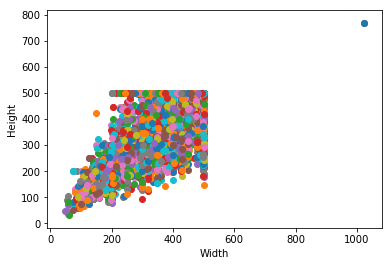

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from PIL import Image

plt.xlabel('Width')    #x轴名称
plt.ylabel('Height')  #y轴名称
for i in range(1000):
    img=Image.open('train//cat.%s.jpg'%i)
    x=img.size[0]
    y=img.size[1] 
    plt.scatter(x,y)       #训练集准确率曲线
for i in range(1000):
    img=Image.open('train//dog.%s.jpg'%i)
    x=img.size[0]
    y=img.size[1] 
    plt.scatter(x,y)
plt.figure()
plt.show()

# 导出特征向量

In [23]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py
import numpy as np
from sklearn.utils import shuffle


input_tensor = Input((299, 299, 3))  #使用inception_v3需要的图片尺寸（299,299）
x = input_tensor
x = Lambda(inception_v3.preprocess_input)(x)  #使用inception_v3网络


train_data_generator = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)  #对训练集中的图片进行提升

image_generator = ImageDataGenerator()

#将训练集和测试集中的数据读入两个不同的generator并resize
train_generator = train_data_generator.flow_from_directory("train_data", (299, 299),batch_size=32, shuffle = False)
#将训练集和验证集分开处理，保证被增强过的数据不进入验证集
validation_generator = image_generator.flow_from_directory("val_data",(299, 299),batch_size=32,shuffle = False)
test_generator = image_generator.flow_from_directory("test_data", (299, 299),batch_size=32, class_mode=None,shuffle=False)

base_model = InceptionV3(input_tensor=x,weights='imagenet', include_top=False)  #只引用InceptionV3特征网络层，不需要顶层
model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))  #平均化图片特征

#读出数据集由预训练过的inception_v3卷积网络层得出的特征向量
train_processed = model.predict_generator(train_generator,train_generator.samples//train_generator.batch_size)
val_processed = model.predict_generator(validation_generator,validation_generator.samples//validation_generator.batch_size+1)
test_processed = model.predict_generator(test_generator,test_generator.samples//test_generator.batch_size+1)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


# 将导出的特征向量保存为.h5文件

In [24]:
with h5py.File("model_test.h5") as h:   #将读到的特征向量写成.h5文件方便以后调用。将训练集和验证集分开处理。
        h.create_dataset("train", data=train_processed)          #写入训练集特征
        h.create_dataset("label", data=train_generator.classes)  #写入训练集标签
        
        h.create_dataset("val", data=val_processed)              #写入验证集特征
        h.create_dataset("val_label", data=validation_generator.classes)  #写入验证集标签
        
        h.create_dataset("test", data=test_processed)   #写入测试集
     
print(len(train_processed))  #应该20000
print(len(val_processed))    #应该5000

20000
5000
